In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from skmultiflow.drift_detection import DDM, ADWIN

/var/folders/5s/7k6w3ysd6db9hs3hnmc7tw9m0000gn/T/ipykernel_6843/4066386246.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
housing_dataset = pd.read_csv('housing.csv')

In [3]:
housing_dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Clean Up Data

In [4]:
housing_dataset.dropna(inplace=True)
housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

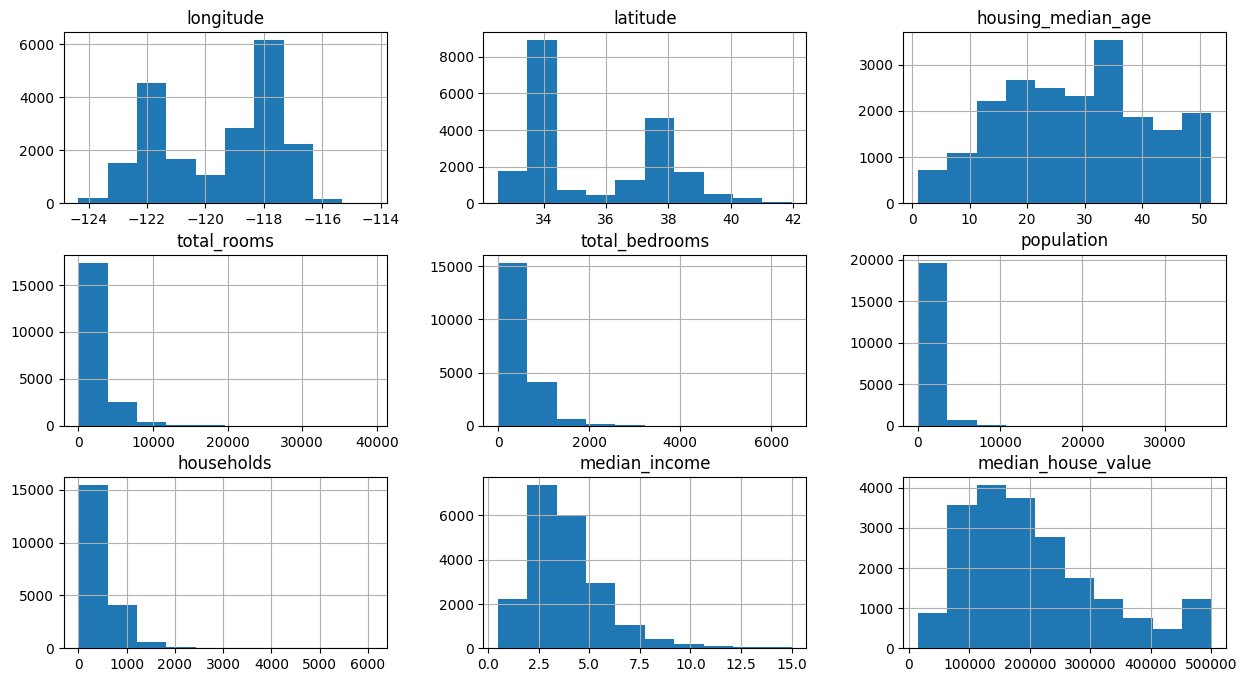

In [5]:
housing_dataset.hist(figsize=(15,8))

## Make it look like a Gaussion Bell Curve

In [6]:
dataset = housing_dataset.copy()
dataset['total_rooms'] = np.log(dataset['total_rooms'] + 1 )
dataset['total_bedrooms'] = np.log(dataset['total_bedrooms'] + 1 )
dataset['population'] = np.log(dataset['population'] + 1 )
dataset['households'] = np.log(dataset['households'] + 1 )

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

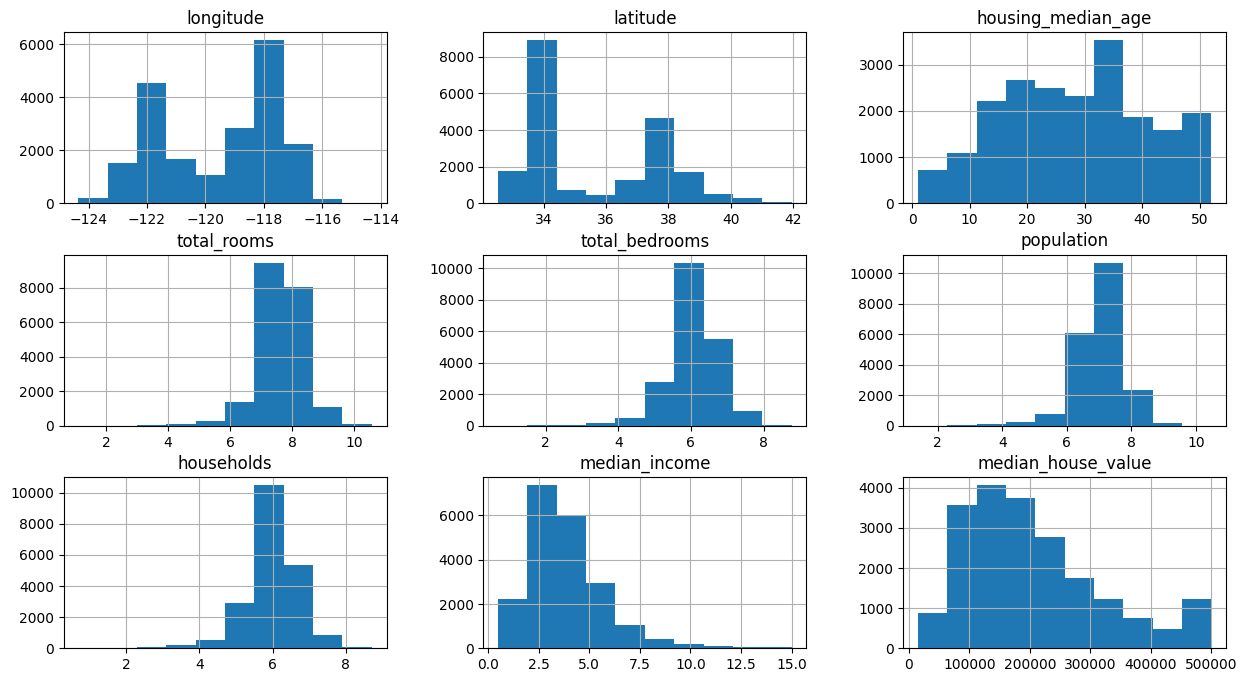

In [7]:
dataset.hist(figsize=(15,8))

## Turn Ocean Proximity into Numerical Attribute

In [8]:
dataset.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [9]:
dataset = dataset.join(pd.get_dummies(dataset.ocean_proximity)).drop(['ocean_proximity'], axis=1)

In [10]:
dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,7.291656,5.252273,6.208590,5.181784,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,7.150701,5.463832,6.326149,5.393628,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,7.395108,5.638355,6.338594,5.560682,3.8462,342200.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.418181,5.926926,6.740519,5.802118,1.5603,78100.0,False,True,False,False,False
20636,-121.21,39.49,18.0,6.548219,5.017280,5.877736,4.744932,2.5568,77100.0,False,True,False,False,False
20637,-121.22,39.43,17.0,7.720905,6.186209,6.915723,6.073045,1.7000,92300.0,False,True,False,False,False
20638,-121.32,39.43,18.0,7.528869,6.016157,6.609349,5.857933,1.8672,84700.0,False,True,False,False,False


<Axes: >

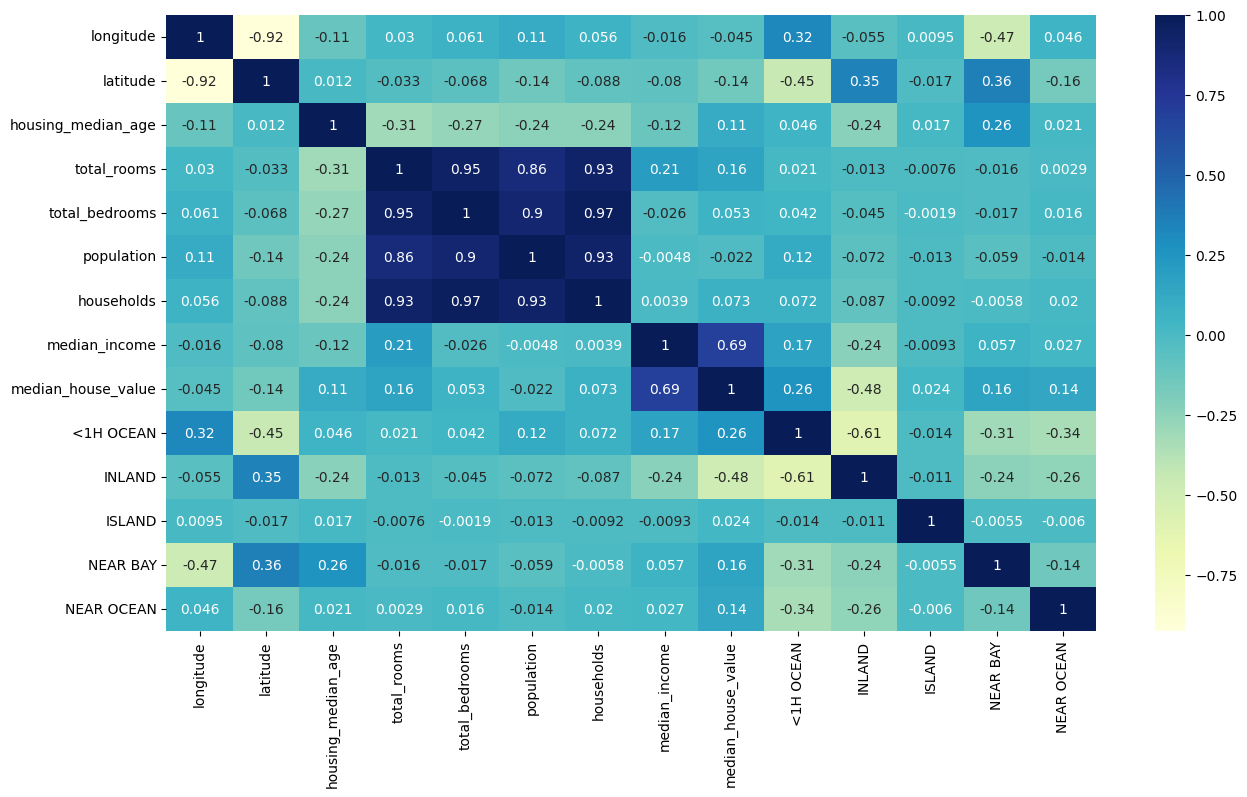

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(dataset.corr(), annot=True, cmap='YlGnBu')

## What does the Heatmap show us?
### the correlation for INLAND to Median House Value is negative -> so it means that we are paying way less than being NEAR OCEAN. And the most expensive House Values are correlated to the <1h Oceans Attribute

<Axes: xlabel='latitude', ylabel='longitude'>

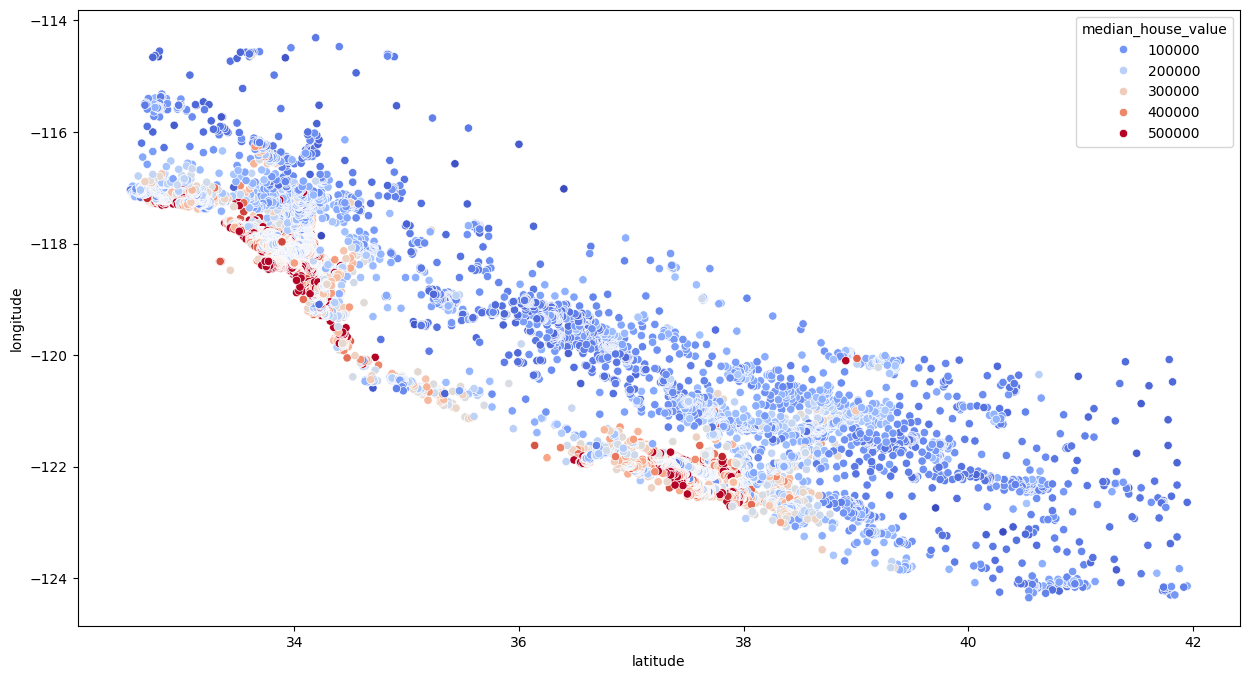

In [12]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="latitude", y="longitude", data=dataset, hue="median_house_value", palette="coolwarm")

## What does this plot shows us?
### Through out the Plot we can see the shap of California. We can see that the House Value is significantly higher near the Ocean. We reach the most expensive Households close to San Francisco and Los Angeles

# Feature Engineering
### Create a correlation between Household, Bedrooms and House Value

In [13]:
dataset['bedroom_ratio'] = dataset['total_bedrooms'] / dataset['total_rooms']
dataset['households_rooms'] = dataset['total_rooms'] / dataset['households']

<Axes: >

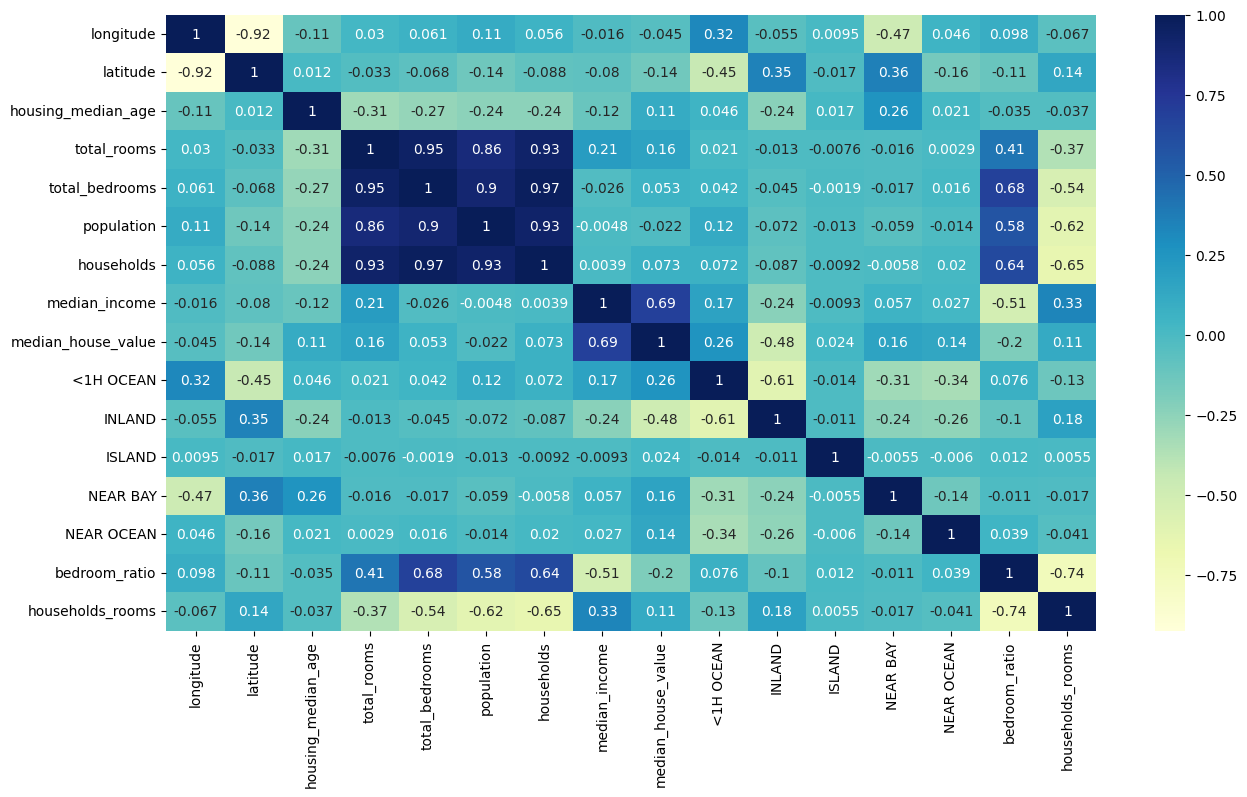

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(dataset.corr(), annot=True, cmap='YlGnBu')

## What does the Plot shows us?
### We can see that the new added Attribute Bedroom Ratio has a negative impact to the House Value. And the households are not as much important than the Household Rooms correlated to the House Value. Also, Total Bedrooms are not as much important than the Total number of Rooms

# Split Up Data into Test and Train

In [15]:
X = dataset.drop(['median_house_value'], axis=1)
y = dataset['median_house_value']
dataset

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,households_rooms
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,8.3252,452600.0,False,False,False,True,False,0.717813,1.399834
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,8.3014,358500.0,False,False,False,True,False,0.790429,1.260013
2,-122.24,37.85,52.0,7.291656,5.252273,6.208590,5.181784,7.2574,352100.0,False,False,False,True,False,0.720313,1.407171
3,-122.25,37.85,52.0,7.150701,5.463832,6.326149,5.393628,5.6431,341300.0,False,False,False,True,False,0.764097,1.325768
4,-122.25,37.85,52.0,7.395108,5.638355,6.338594,5.560682,3.8462,342200.0,False,False,False,True,False,0.762444,1.329892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.418181,5.926926,6.740519,5.802118,1.5603,78100.0,False,True,False,False,False,0.798973,1.278530
20636,-121.21,39.49,18.0,6.548219,5.017280,5.877736,4.744932,2.5568,77100.0,False,True,False,False,False,0.766205,1.380045
20637,-121.22,39.43,17.0,7.720905,6.186209,6.915723,6.073045,1.7000,92300.0,False,True,False,False,False,0.801228,1.271340
20638,-121.32,39.43,18.0,7.528869,6.016157,6.609349,5.857933,1.8672,84700.0,False,True,False,False,False,0.799078,1.285243


In [16]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20433, dtype: float64

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
train_data = X_train.join(y_train)
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,households_rooms,median_house_value
15610,-116.87,32.72,13.0,8.092239,6.198479,7.266827,6.222576,5.7652,True,False,False,False,False,0.765978,1.300464,259900.0
12478,-121.48,38.59,52.0,7.079184,5.834811,6.946014,5.771441,1.6116,False,True,False,False,False,0.824221,1.226589,70500.0
5996,-117.73,34.09,36.0,7.342132,5.697093,7.212294,5.717028,3.5313,False,True,False,False,False,0.775945,1.284257,117800.0
11827,-121.02,39.01,17.0,8.473659,6.684612,7.633854,6.647688,3.9734,False,True,False,False,False,0.788870,1.274678,185400.0
5183,-118.26,33.94,41.0,7.320527,6.018593,7.250636,5.966147,1.6500,True,False,False,False,False,0.822153,1.227011,94200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13246,-117.63,34.12,4.0,8.371936,6.654153,7.299797,6.498282,6.0758,False,True,False,False,False,0.794816,1.288331,226800.0
19844,-119.09,36.42,17.0,6.777647,5.393628,6.874198,5.389072,2.0000,False,True,False,False,False,0.795797,1.257665,52500.0
9944,-122.26,38.16,23.0,7.951911,6.198479,7.369601,6.146329,4.0337,False,False,False,True,False,0.779495,1.293766,130400.0
10908,-117.86,33.74,9.0,6.265301,5.147494,7.137278,5.111988,3.3750,True,False,False,False,False,0.821588,1.225610,165300.0


In [18]:
test_data = X_test
test_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,households_rooms
14185,-117.08,32.70,37.0,7.685703,6.037871,7.171657,5.929589,2.8750,False,False,False,False,True,0.785598,1.296161
6125,-117.91,34.11,20.0,8.058011,6.529419,7.781973,6.570883,3.5250,True,False,False,False,False,0.810302,1.226321
14095,-117.10,32.75,11.0,7.780721,6.588926,7.552762,6.568078,1.3448,False,False,False,False,True,0.846827,1.184627
14359,-117.22,32.74,52.0,7.139660,5.313206,6.320768,5.347108,7.2758,False,False,False,False,True,0.744182,1.335238
18004,-121.99,37.29,32.0,7.983099,6.177944,7.198184,6.177944,6.4631,True,False,False,False,False,0.773878,1.292193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19533,-120.91,37.66,36.0,7.186144,5.545177,6.580639,5.451038,2.6523,False,True,False,False,False,0.771648,1.318307
7695,-118.11,33.96,29.0,7.932003,6.368187,7.153834,6.311735,4.3882,True,False,False,False,False,0.802847,1.256707
15558,-117.07,33.12,12.0,7.805475,6.396930,7.132498,6.272877,2.4122,True,False,False,False,False,0.819544,1.244321
16731,-120.49,35.35,17.0,8.020928,6.411818,7.284821,6.302619,3.1641,True,False,False,False,False,0.799386,1.272634


# Train Our Model using
## 1. linear regression with scaling

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

In [20]:
X_test_scaled = scaler.transform(X_test)

In [21]:
reg.score(X_test_scaled, y_test)

0.6779323344640635

### We see our Model score is at 67%. We have to optimize the Model to get at least over 80%

## 2. Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X_train_scaled, y_train)
forest.score(X_test_scaled, y_test)

0.8132674251462593

### We see our Model scores with over 80% but we can optimize it even further with grid search and cross validation

In [23]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor(n_estimators=100, random_state=0) 

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_features': [8, 12, 20],
    "min_samples_split": [2, 4, 6, 8],
}

grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 2, n_jobs = -1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_features=8, min_samples_split=2, n_estimators=30; total time=   1.2s
[CV] END max_features=8, min_samples_split=2, n_estimators=30; total time=   1.3s
[CV] END max_features=8, min_samples_split=2, n_estimators=30; total time=   1.3s
[CV] END max_features=8, min_samples_split=2, n_estimators=30; total time=   1.3s
[CV] END max_features=8, min_samples_split=2, n_estimators=30; total time=   1.4s
[CV] END max_features=8, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_features=8, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_features=8, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_features=8, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_features=8, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_features=8, min_samples_split=4, n_estimators=30; total time=   1.2s
[CV] END max_features=8, min_samples

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_features': [8, 12, 20],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [24]:
best_forest = grid_search.best_estimator_

In [25]:
best_forest.score(X_test_scaled, y_test)

0.816336972039517

### We optimized it even further to get a score from 81.3% to 81.6%

# Clean Data Model (before any Feature Engineering)

For results comparing

In [26]:
clean_data = housing_dataset.copy()

clean_data = clean_data.join(pd.get_dummies(clean_data.ocean_proximity)).drop(['ocean_proximity'], axis=1) # Have to change the ocean proximity because it doesn't work with random strings 

clean_X = clean_data.drop(['median_house_value'], axis=1)
clean_Y = clean_data['median_house_value']


In [27]:
clean_X_train, clean_X_test, clean_y_train, clean_y_test = train_test_split(clean_X, clean_Y, test_size=0.2, random_state=0)

## 1. linear regression with scaling

In [28]:
scaler = StandardScaler()

clean_X_train_scaled = scaler.fit_transform(clean_X_train)

reg = LinearRegression()
reg.fit(clean_X_train_scaled, clean_y_train)
clean_X_test_scaled = scaler.transform(clean_X_test)
reg.score(clean_X_test_scaled, clean_y_test)

0.652609666453112

## 2. Random forest

In [29]:
clean_forest = RandomForestRegressor(n_estimators=100, random_state=0)
clean_forest.fit(clean_X_train_scaled, clean_y_train)
clean_forest.score(clean_X_test_scaled, clean_y_test)

0.8195494411645816

In [30]:
clean_forest = RandomForestRegressor(n_estimators=100, random_state=0) 

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_features': [8, 12, 20],
    "min_samples_split": [2, 4, 6, 8],
}

clean_grid_search = GridSearchCV(estimator=clean_forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = 1, n_jobs = -1)
clean_grid_search.fit(clean_X_train_scaled, clean_y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_features': [8, 12, 20],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [31]:
clean_best_forest = clean_grid_search.best_estimator_
clean_best_forest.score(clean_X_test_scaled, clean_y_test)

0.82597958617302

# Drift Detection

## Kolmonogorov-Smirnov (K-S) Test
A test used for detecting whether two samples come from the same distribution. This way we can detect a drift in feature's distribution(only for continuous distribution) or target drift. 

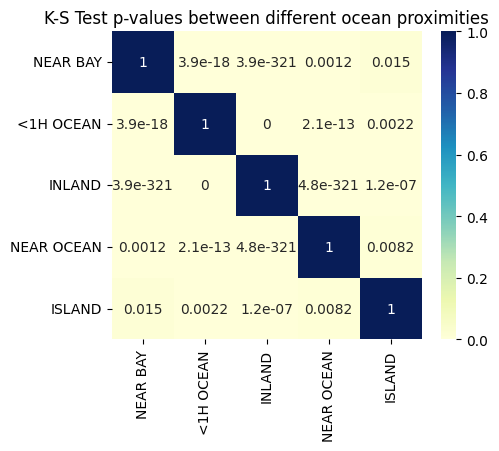

In [32]:
# Checking how different are target distributions for different ocean proximity
ocean_proximities = housing_dataset.ocean_proximity.unique()
ocean_proximities_datasets = [housing_dataset[housing_dataset.ocean_proximity == ocean_proximity].median_house_value for ocean_proximity in ocean_proximities]

size = len(ocean_proximities)
p_values_matrix = np.zeros((size, size))
# Compute p-values for each pair of distributions
for i in range(size):
    for j in range(size):
        result = stats.kstest(ocean_proximities_datasets[i], ocean_proximities_datasets[j]) # The null hypothesis is that the two distributions are identical
        p_values_matrix[i, j] = result.pvalue

# Create heatmap of p-values
plt.figure(figsize=(5, 4))
sns.heatmap(p_values_matrix, annot=True, cmap="YlGnBu", xticklabels=ocean_proximities, yticklabels=ocean_proximities)
plt.title("K-S Test p-values between different ocean proximities")
plt.show()

Clearly distributions of target values are different for different ocean proximity.

##  ADaptive WINdowing Drift Detection

Can detect concept drift in the stream of data.

### Testing sorted houses' prices for data drift

In [75]:
from skmultiflow.drift_detection import DDM
ddm = ADWIN()

detected_changes = []

for index, value  in y.items():
    ddm.add_element(value)
    if ddm.detected_change():
        detected_changes.append(index)
        print('Change has been detected in data: ' + str(value) + ' - of index: ' + str(index))

Change has been detected in data: 115200.0 - of index: 31
Change has been detected in data: 76100.0 - of index: 63
Change has been detected in data: 292300.0 - of index: 127
Change has been detected in data: 217100.0 - of index: 223
Change has been detected in data: 98700.0 - of index: 255
Change has been detected in data: 100400.0 - of index: 353
Change has been detected in data: 371300.0 - of index: 417
Change has been detected in data: 212000.0 - of index: 449
Change has been detected in data: 250000.0 - of index: 481
Change has been detected in data: 466100.0 - of index: 513
Change has been detected in data: 172700.0 - of index: 773
Change has been detected in data: 235300.0 - of index: 837
Change has been detected in data: 216800.0 - of index: 997
Change has been detected in data: 139200.0 - of index: 1093
Change has been detected in data: 87300.0 - of index: 1126
Change has been detected in data: 96200.0 - of index: 1190
Change has been detected in data: 273200.0 - of index: 1415

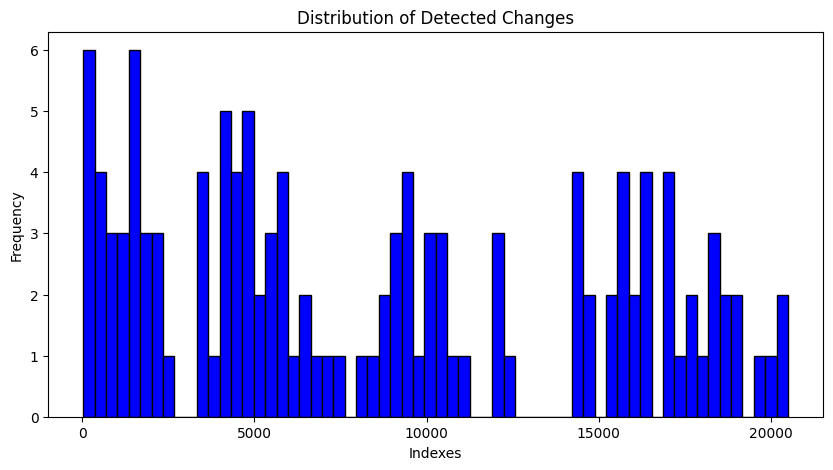

In [77]:
def plot_index_distribution(indexes):
    plt.figure(figsize=(10, 5))
    plt.hist(indexes, bins=len(set(indexes))//2, color='blue', edgecolor='black')
    plt.title('Distribution of Detected Changes')
    plt.xlabel('Indexes')
    plt.ylabel('Frequency')
    plt.show()

plot_index_distribution(detected_changes)

### Testing if the model can deal with such data drift

In [53]:

# proportion for diving into evaluation and train/test
def get_stream_data_model(X, y, proportion = 0.5, logging = 1): 

    midpoint = int(len(X)*proportion)

    # Data for training and testing
    X_test_and_train = X.iloc[:midpoint]
    y_test_and_train = y.iloc[:midpoint]

    # Data that comes in a stream for evaluation
    X_stream = X.iloc[midpoint:]
    y_stream = y.iloc[midpoint:]

    X_train, X_test, y_train, y_test = train_test_split(X_test_and_train, y_test_and_train, test_size=0.3, random_state=0)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_stream_scaled = scaler.transform(X_stream)

    forest = RandomForestRegressor( random_state=0) 

    param_grid = {
        'n_estimators': [30, 50, 100],
        'max_features': [6, 8, 12],
        "min_samples_split": [2, 4, 6, 8],
    }

    grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose = logging, n_jobs = -1)
    grid_search.fit(X_train_scaled, y_train)

    # Score on test data 
    test_score = grid_search.best_estimator_.score(X_test_scaled, y_test)

    if(logging > 0):
        print("Test score = " + str(test_score))

    return grid_search.best_estimator_ , X_stream_scaled, y_stream




In [54]:

# Getting a model trained on first half of the stream in order to evaluate it on the other half of the stream
ADWIN_best_forest, ADWIN_X_stream, ADWIN_y_stream = get_stream_data_model(X,y,logging=1, proportion=0.5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Test score = 0.8501329199828291


### Score the model on stream data

In [55]:
ADWIN_best_forest.score(ADWIN_X_stream, ADWIN_y_stream)

0.6101925940896404

The results are much worse than desirable. To adjust the model to the data drift we would need continual learning methods.

In [78]:
ADWIN_y_stream_predicted = ADWIN_best_forest.predict(ADWIN_X_stream)

In [83]:
from skmultiflow.drift_detection import DDM
ddm = ADWIN()

detected_changes_in_prediction = []

for i in range(len(ADWIN_y_stream_predicted)):
    ddm.add_element(ADWIN_y_stream_predicted[i])
    if ddm.detected_change():
        detected_changes_in_prediction.append(i)

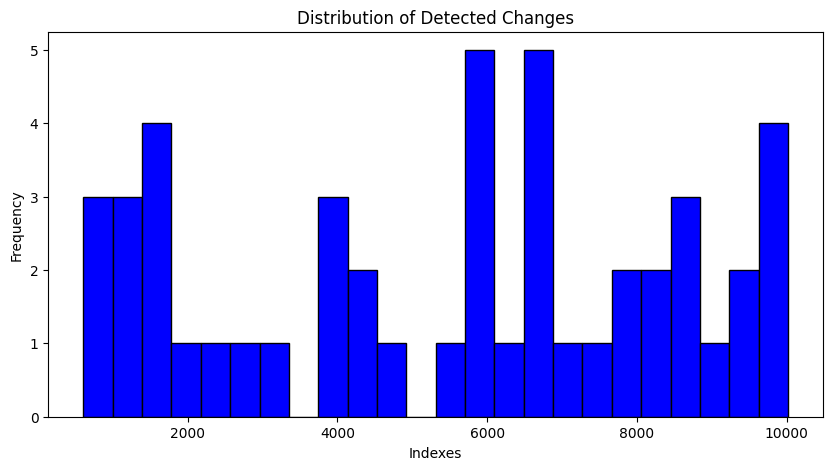

In [93]:
plot_index_distribution(detected_changes_in_prediction)

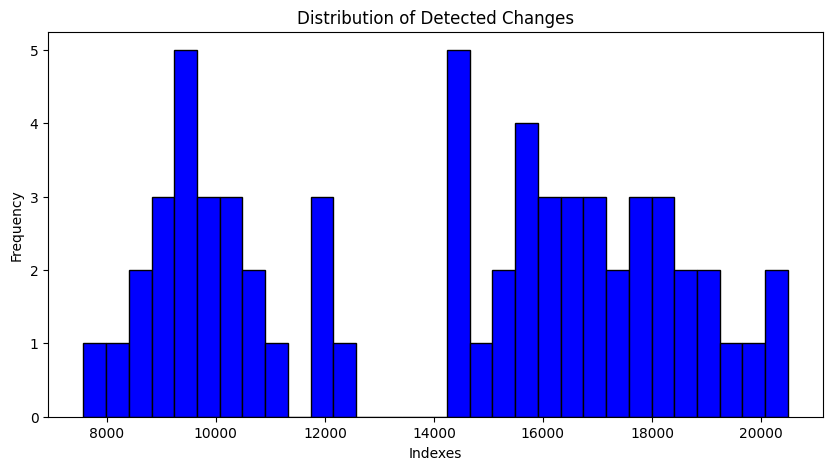

In [94]:
plot_index_distribution(detected_changes[len(detected_changes)//2:])